In [5]:
import os
import json
import logging
from typing import List, Callable, Optional

import firebase_admin
from firebase_admin import credentials, firestore

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import scipy.signal as signal

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')


In [7]:
def initialize_firebase(cred_path: str = 'adminKey.json') -> firestore.Client:
    """Initializes Firebase using the provided credentials."""
    cred = credentials.Certificate(cred_path)
    #firebase_admin.initialize_app(cred)
    return firestore.client()

# Initialize Firebase (Ensure 'adminKey.json' is available in your working directory)
db = initialize_firebase()

In [8]:
class AccelerometerDataset(Dataset):
    def __init__(self,
                 collection: str,
                 include_people: List[str],
                 include_activities: List[str],
                 load_from_cache: bool = False,
                 cache_file: Optional[str] = None):
        self.collection = collection
        self.include_people = include_people
        self.include_activities = include_activities
        self.load_from_cache = load_from_cache
        self.cache_file = cache_file if cache_file else f'{collection}_cache.json'

        self.data: List[List[List[float]]] = []
        self.labels: List[int] = []

        if load_from_cache and os.path.exists(self.cache_file):
            self._load_cache()
        else:
            self._fetch_from_firestore()
            self._save_cache()

    def _load_cache(self):
        logging.info(f"Loading cached data from {self.cache_file}")
        with open(self.cache_file, 'r') as f:
            cache = json.load(f)
            self.data = cache.get("data", [])
            self.labels = cache.get("labels", [])

    def _save_cache(self):
        logging.info(f"Saving data to {self.cache_file}")
        with open(self.cache_file, 'w') as f:
            json.dump({"data": self.data, "labels": self.labels}, f)

    def _fetch_from_firestore(self):
        logging.info(f"Fetching {self.collection} data from Firestore...")
        for person_doc in db.collection(self.collection).stream():
            person_data = person_doc.to_dict()
            person_name = person_data.get('name')
            if person_name not in self.include_people:
                continue

            for act_idx, activity in enumerate(self.include_activities):
                activity_collection = db.collection(self.collection).document(person_name).collection(activity)
                for record_doc in activity_collection.stream():
                    record = record_doc.to_dict()
                    accelerations = record.get('acceleration', [])
                    if len(accelerations) < 600:
                        continue
                    trimmed = accelerations[300:-300]
                    num_chunks = len(trimmed) // 200
                    for i in range(num_chunks):
                        chunk = trimmed[i * 200:(i + 1) * 200]
                        sample = [[m['x'], m['y'], m['z']] for m in chunk]
                        self.data.append(sample)
                        self.labels.append(act_idx)
        logging.info(f"Fetched {len(self.data)} samples from Firestore")

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, index: int):
        return np.array(self.data[index]), self.labels[index]

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes: int):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, 5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool1d(2, stride=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.mean(dim=2)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

class CNN_LSTM_Model(nn.Module):
    def __init__(self, num_classes: int):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, 5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, 5, padding=2)
        self.lstm = nn.LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.permute(0, 2, 1)
        _, (hn, _) = self.lstm(x)
        x = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.fc(x)

In [21]:
def train_model(model, train_loader, optimizer, criterion, device, num_epochs=10):
    model.train()
    epoch_losses = []  # Store losses for plotting
    
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float().permute(0, 2, 1), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        logging.info(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    # Plot loss over epochs
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid()
    plt.show()

import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float().permute(0, 2, 1), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute accuracy
    accuracy = 100 * sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    logging.info(f"Accuracy: {accuracy:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

2025-02-08 09:23:49,533 [INFO] Fetching training data from Firestore...
2025-02-08 09:23:53,334 [INFO] Fetched 111 samples from Firestore
2025-02-08 09:23:53,336 [INFO] Saving data to training_cache.json
2025-02-08 09:23:53,550 [INFO] Fetching testing data from Firestore...
2025-02-08 09:23:57,097 [INFO] Fetched 95 samples from Firestore
2025-02-08 09:23:57,100 [INFO] Saving data to testing_cache.json
2025-02-08 09:23:57,427 [INFO] Epoch [1/20] Loss: 1.3720
2025-02-08 09:23:57,596 [INFO] Epoch [2/20] Loss: 1.3321
2025-02-08 09:23:57,758 [INFO] Epoch [3/20] Loss: 1.2866
2025-02-08 09:23:57,907 [INFO] Epoch [4/20] Loss: 1.2033
2025-02-08 09:23:58,070 [INFO] Epoch [5/20] Loss: 1.0966
2025-02-08 09:23:58,230 [INFO] Epoch [6/20] Loss: 0.9651
2025-02-08 09:23:58,390 [INFO] Epoch [7/20] Loss: 0.8739
2025-02-08 09:23:58,557 [INFO] Epoch [8/20] Loss: 0.8871
2025-02-08 09:23:58,746 [INFO] Epoch [9/20] Loss: 0.7475
2025-02-08 09:23:58,917 [INFO] Epoch [10/20] Loss: 0.7565
2025-02-08 09:23:59,079 

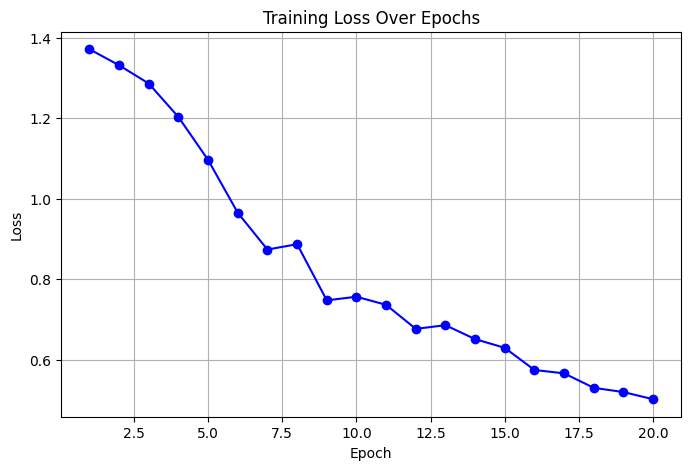

2025-02-08 09:24:00,767 [INFO] Accuracy: 84.21%


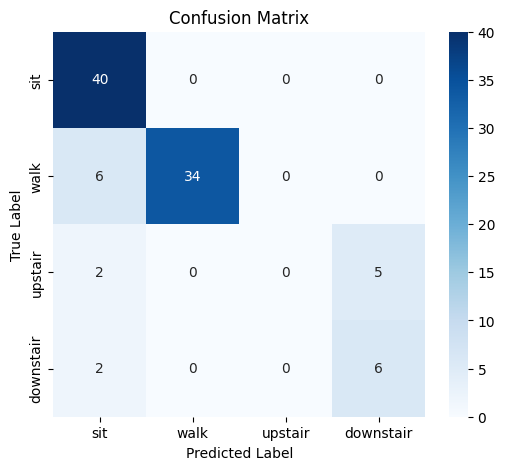

In [23]:
# Configuration
include_people = ['Stephen','Ren','Lillian']
include_activities = ['sit','walk','upstair','downstair']
batch_size = 32
num_epochs = 20
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loaders
train_dataset = AccelerometerDataset('training', include_people, include_activities)
test_dataset = AccelerometerDataset('testing', include_people, include_activities)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = CNN(len(include_activities)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train & Evaluate
train_model(model, train_loader, optimizer, criterion, device, num_epochs)
evaluate_model(model, test_loader, device, include_activities)
